# Functions

In [1]:
import osmnx as ox
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd
import random
import math
from collections import Counter

In [2]:
def clean_speed_limit(G):
    speed_dictionary = {
        "primary": 40, "motorway": 70, "secondary": 30, "residential": 20,
        "service": 40, "trunk": 70, "other": 20, "tertiary": 20
    }
    
    for u, v, key, data in G.edges(data=True, keys=True):
        speed = data.get('maxspeed', None)
        clean_speed = None

        # Handle speeds provided as lists
        if isinstance(speed, list):
            cleaned_speeds = []
            for s in speed:
                if 'mph' in s:
                    cleaned_speeds.append(int(s.replace(' mph', '')) * 0.44704)
                elif 'km/h' in s:
                    cleaned_speeds.append(int(float(s.replace(' km/h', '')) * 0.621371 * 0.44704))
            clean_speed = max(cleaned_speeds) if cleaned_speeds else None

        # Handle speeds provided as strings
        elif isinstance(speed, str):
            if 'mph' in speed:
                clean_speed = int(speed.replace(' mph', '')) * 0.44704
            elif 'km/h' in speed:
                clean_speed = int(float(speed.replace(' km/h', '')) * 0.621371 * 0.44704)
            else:
                try:
                    clean_speed = int(speed) * 0.44704  # Convert direct integers to m/s
                except ValueError:
                    print(f"Unexpected type or format at edge ({u}, {v}): {speed}")
                    continue

        # Use the highway type to set a default speed
        if clean_speed is None:
            highway_type = data.get('highway', 'other')
            # Ensure highway_type is not a list
            if isinstance(highway_type, list):
                highway_type = highway_type[0] if highway_type else 'other'
            clean_speed = speed_dictionary.get(highway_type, 20) * 0.44704

        # Assign the cleaned speed back to the data
        data['speed_m/s'] = clean_speed

    return G


In [3]:
def nat_time(G): 
    
    for u, v, data in G.edges(data=True):
        # Use get method to safely access 'maxspeed' key with a default of None
        speed = data.get('maxspeed', None)

        data["nat_time"] = data["length"]/data["speed_m/s"]

    return 

In [4]:
def Capacity(G):
    capacity_dictionary = {
        "primary": 100, "motorway": 200, "secondary": 50, "residential": 10,
        "service": 70, "trunk": 70, "other": 10, "tertiary": 20
    }
    
    for u, v, data in G.edges(data=True):
        name = data["highway"]
        # Correcting the type check for a list
        if isinstance(name, list):
            name = name[0]  # Use the first type if there are multiple types
        
        # Using get to avoid KeyErrors if the highway type is not in the dictionary
        data["capacity"] = capacity_dictionary.get(name, 20)  # Default capacity is 20 if not found
        
    return   # Optional: return the graph if you want to chain or validate

In [30]:
def other_edge_attributes(G):
    for u, v, key, data in G.edges(keys=True, data=True):
        data["usage"] = 0
        data["dyn_time"] = data["nat_time"]
        data["per_time"] = data["nat_time"]
    return


In [41]:
def generate_agents(G, algorithms, algorithm_weights, orig_points, dest_points, num_agents, start_nodes, end_nodes, using_nodes=True):
    """
    Generate a list of agents with specified algorithms, start nodes, and end nodes.

    Args:
    - algorithms (list): List of algorithms.
    - algorithm_weights (list): List of weights corresponding to algorithms.
    - start_nodes (list): List of tuples representing start nodes with corresponding weights.
    - end_nodes (list): List of tuples representing end nodes with corresponding weights.
    - num_agents (int): Number of agents to generate.

    Returns:
    - agents (list): List of dictionaries representing agents.
    """
    if using_nodes is False: 
        start_nodes, end_nodes=  convert_points_to_nodes(orig_points, dest_points, G)
        
    agents = []
    
    for _ in range(num_agents):
        start_node = random.choices([node[0] for node in start_nodes], weights=[node[1] for node in start_nodes])[0]
        end_node = random.choices([node[0] for node in end_nodes], weights=[node[1] for node in end_nodes])[0]
        algorithm = random.choices(algorithms, weights=algorithm_weights)[0]
        agent = {'start_node': start_node, 'end_node': end_node, 'algorithm': algorithm}
        agents.append(agent)
    
    return agents

In [7]:
def convert_points_to_nodes(orig_points, dest_points, G):
    
    orig_nodes = []
    dest_nodes = []
    
    for orig_tuple in orig_points:
        orig_point = orig_tuple[0]
        orig_weight = orig_tuple[1]

        # Get longitude and latitude from the points
        orig_node_lon, orig_node_lat = orig_point.x, orig_point.y
        print(orig_node_lon, orig_node_lat , orig_point.x, orig_point.y)
        orig_node = ox.distance.nearest_nodes(G, orig_node_lon, orig_node_lat)
        print("orig_node", orig_node)
        orig_nodes.append((orig_node,orig_weight))
        
    
    for dest_tuple in dest_points:
        dest_point = dest_tuple[0]
        dest_weight = dest_tuple[1]
        
        dest_node_lon, dest_node_lat = dest_point.x, dest_point.y
                
        print(dest_node_lon, dest_node_lat ,dest_point.x, dest_point.y)
        dest_node = ox.distance.nearest_nodes(G, dest_node_lon, dest_node_lat)
        print ("dest_node", dest_node)
        dest_nodes.append((dest_node,dest_weight))
    
    return orig_nodes, dest_nodes


In [38]:


elastic_coeff = 1  # defines how elastic the response is in the dynamic time calculation

def calculate_total_dyn_time(Graph, path):
    total_dyn_time = 0
    for i in range(len(path) - 1):
        dyn_time =0
        u, v = path[i], path[i + 1]
        # Assuming we are picking the first available edge by default
        edge_key = list(Graph[u][v])[0]
        dyn_time = Graph[u][v][edge_key]['dyn_time']
       # print("dyn_time: ", Graph[u][v][edge_key]['dyn_time'], "  usage: ",Graph[u][v][edge_key]['usage'], "  capacity: ", Graph[u][v][edge_key]['capacity'], "  nat_time: ", Graph[u][v][edge_key]['nat_time'])
        total_dyn_time += dyn_time
       # print("dyn_time", dyn_time)
    return total_dyn_time

def update_edge_usage(Graph, path):
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        edge_key = list(Graph[u][v])[0]  # Pick the first available edge by default
        if Graph.has_edge(u, v, edge_key):
            Graph[u][v][edge_key]['usage'] += 1

def update_dyn_time(Graph):
    for u, v, key in Graph.edges(keys=True):
        data = Graph[u][v][key]
        #print(data)
        nat_time = data['nat_time']
        capacity = data['capacity']
        usage = data['usage']
        #print(capacity)
        if capacity == 0:
            capacity =5 ## defualt error value
        if usage == 0:
            Graph[u][v][key]['dyn_time'] = nat_time
        else:
            Graph[u][v][key]['dyn_time'] = nat_time * (1+  (usage / capacity))

def update_per_time(Graph):
    for u, v, key in Graph.edges(keys=True):
        data = Graph[u][v][key]
        nat_time = data['nat_time']
        dyn_time = data['dyn_time']
        Graph[u][v][key]['per_time'] = nat_time + (dyn_time - nat_time) / 2

def route_choice(Graph, agent_style, start, end):
    if agent_style == "Natural":
        shortest_path = nx.shortest_path(Graph, source=start, target=end, weight='nat_time')
    elif agent_style == "Dynamic":
        shortest_path = nx.shortest_path(Graph, source=start, target=end, weight='dyn_time')
    elif agent_style == "Percieved":
        shortest_path = nx.shortest_path(Graph, source=start, target=end, weight='per_time')
    return shortest_path

def agent_traverse(Graph, agent):
    shortest_path = route_choice(Graph, agent["algorithm"], agent["start_node"], agent["end_node"])
    total_dyn_time = calculate_total_dyn_time(Graph, shortest_path)
    update_edge_usage(Graph, shortest_path)
    update_dyn_time(Graph)
    update_per_time(Graph)
    #print("total dyn time: ", total_dyn_time)
    return shortest_path, total_dyn_time

def network_efficiency(Graph, agents):
    total_agent_path_length = 0
    total_agents = 0
    all_agent_paths = []
    all_agent_paths_return = []

    for agent in agents:
        agent_path, agent_path_length = agent_traverse(Graph, agent)
       # print(f"Agent {agent} Path:", agent_path)
       # print(f"Agent {agent} Path Length:", agent_path_length)
        total_agent_path_length += agent_path_length
        total_agents += 1
        all_agent_paths.append(tuple(agent_path))
        all_agent_paths_return.append([agent_path])

    most_common_path = Counter(all_agent_paths).most_common(1)[0][0]
    average_agent_path_length = total_agent_path_length / total_agents
   # print("Most common path:", most_common_path)
    #print("average path length: ", average_agent_path_length)
    return all_agent_paths_return, most_common_path, average_agent_path_length
def reset_edge_attributes(Graph):
    for u, v, key in Graph.edges(keys=True):
        data = Graph[u][v][key]
        data['dyn_time'] = data['nat_time']
        data['per_time'] = data['nat_time']
        if data["node_type"] == "urban":
            data['usage'] = 3
        elif data["node_type"] == "suburban":
            data['usage'] = 15


In [9]:
def filter_highway_types(G):
    
    allowed_types = [
        "primary" ,"motorway" ,"secondary"
        "service",  "trunk" , "tertiary" ]
    
    # Create a list to hold edges that do not meet the criteria
    edges_to_remove = []

    # Iterate over all edges in the graph
    for u, v, data in G.edges(data=True):
        highway_type = data.get('highway', None)

        # Check if the highway type is a list (sometimes multiple types are tagged)
        if isinstance(highway_type, list):
            # Check if there is no intersection with allowed types
            if not any(ht in allowed_types for ht in highway_type):
                edges_to_remove.append((u, v))
        elif highway_type not in allowed_types:
            # If the highway type is not in the allowed list
            edges_to_remove.append((u, v))

    # Remove the unwanted edges
    G.remove_edges_from(edges_to_remove)
    
    return G

def remove_edges_by_name(G, edge_name):
    """
    Removes edges from the graph based on the 'name' attribute.

    Parameters:
    - G (networkx.Graph): The graph from which to remove edges.
    - edge_name (str): The name of the edge to remove.

    Returns:
    - None: Modifies the graph in place.
    """
    # List to store edges to be removed to avoid modifying the graph while iterating
    edges_to_remove = []

    # Iterate through all edges and check the 'name' attribute
    for u, v, data in G.edges(data=True):
        if data.get('name') == edge_name:
            edges_to_remove.append((u, v))

    # Remove the collected edges
    for u, v in edges_to_remove:
        G.remove_edge(u, v)
        print(f"Removed edge ({u}, {v}) with name '{edge_name}'")
    return G


def retain_edges_by_names(G, names_to_keep):
    """
    Retains only the edges in the graph whose 'name' attribute matches the names in the provided list.

    Parameters:
    - G (networkx.Graph): The graph from which to filter edges.
    - names_to_keep (list of str): The names of the edges to keep.

    Returns:
    - None: Modifies the graph in place.
    """
    # List to store edges to be removed to avoid modifying the graph while iterating
    edges_to_remove = []

    # Iterate through all edges and check the 'name' attribute
    for u, v, data in G.edges(data=True):
        if data.get('name') not in names_to_keep:
            edges_to_remove.append((u, v))

    # Remove the collected edges
    for u, v in edges_to_remove:
        G.remove_edge(u, v)
        print(f"Removed edge ({u}, {v}) not in the specified names to keep")

    return G


In [10]:
def prepare_and_adjust_graph():
    """
    Create and adjust a graph from a specified bounding box and edge names.

    Parameters:
    - north, south, east, west (float): Geographic coordinates defining the bounding box.
    - names_to_keep (list): List of street names to retain in the graph.

    Returns:
    - G (NetworkX Graph): The prepared and adjusted graph.
    """
    
    
    # Example usage of the function:
    names_to_keep = ["Queens Road", 'Knighton Road', "Chapel Lane", "Welford Road",
                 "Victoria Park Road", "London Road", "Palmerston Way"]
    north = 52.59380748677652
    east = -1.1292476311337287
    south = 52.63371285448154
    west = -1.0880800005905862

    # Create the graph from the bounding box
    G = ox.graph_from_bbox(north, south, east, west, network_type='drive')

    # Convert the network into geodataframes
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

    # Apply various functions to modify the graph's attributes
    Capacity(G)
    clean_speed_limit(G)
    nat_time(G)
    other_edge_attributes(G)

    # Retain only specified edges by names
    retain_edges_by_names(G, names_to_keep)

    # Identify and remove isolated nodes
    isolated = list(nx.isolates(G))
    G.remove_nodes_from(isolated)

    return G

In [11]:
def calculate_edge_betweenness_for_od_pairs(G, od_pairs):
    edge_count = {}
    for (origin, destination) in od_pairs:
        try:
            # Find the shortest path
            path = nx.shortest_path(G, source=origin, target=destination)
            # Count edges in the path
            for i in range(len(path) - 1):
                u, v = path[i], path[i + 1]
                # Handle multigraph
                if G.is_multigraph():
                    for key in G[u][v]:
                        edge = (u, v, key)
                        if edge not in edge_count:
                            edge_count[edge] = 0
                        edge_count[edge] += 1
                else:
                    edge = (u, v)
                    if edge not in edge_count:
                        edge_count[edge] = 0
                    edge_count[edge] += 1
        except nx.NetworkXNoPath:
            print(f"No path between {origin} and {destination}")

    # Normalize the edge counts if necessary
    total_paths = len(od_pairs)
    edge_betweenness = {edge: count / total_paths for edge, count in edge_count.items()}

    # Add the calculated edge betweenness to the graph as an edge attribute
    nx.set_edge_attributes(G, edge_betweenness, 'edge_betweenness')


In [12]:
def calculate_total_effective_capacity(G,no_agents ):
    total_effective_capacity = 0
    
    # Iterate over all edges to calculate the total effective capacity
    for (u, v, data) in G.edges(data=True):
        # Extract edge attributes, ensuring they are treated as numbers
        bc = data.get('edge_betweenness', 0)  # ensure this defaults to 0 if not present
        capacity = data.get('capacity', 1)  # ensure this defaults to 1 if not present
        nat_time = data.get('nat_time', 1)  # ensure this defaults to 1 if not present, assuming nat_time is a numeric attribute
        
        flow  = no_agents*bc 
        dyn_time  = 1 + (flow/capacity)
        
        if capacity > 0 and bc > 0:  # Avoid division by zero
            edge_effective_capacity =  flow*nat_time*( 1 + (flow/capacity)) 
            
            
        else:
            edge_effective_capacity = 0  # Assign zero if capacity or bc is zero to avoid division by zero

        # Accumulate the calculated capacity into the total
        total_effective_capacity += edge_effective_capacity

    return total_effective_capacity/no_agents

In [14]:
def plot_eff_cap(G):
    """
    Plot a NetworkX graph with edges colored by the ratio of usage to capacity.

    Parameters:
    - G (NetworkX Graph): A graph with 'usage' and 'capacity' edge attributes.

    Effects:
    - Displays a matplotlib plot of the graph with edges colored according to their 'usage_to_capacity' ratio.
    """
    # Compute usage to capacity ratio and handle edges with missing data or zero capacity
    for u, v, key, data in G.edges(keys=True, data=True):
        if 'usage' in data and 'capacity' in data and data['capacity'] > 0:
            data['usage_to_capacity'] = data['usage'] / data['capacity']
        else:
            data['usage_to_capacity'] = 0  # Handle cases with missing attributes or zero capacity

    # Normalize and get edge colors based on 'usage_to_capacity'
    nc = ox.plot.get_edge_colors_by_attr(G, 'usage_to_capacity', cmap='coolwarm')

    # Plot the graph using OSMnx with custom edge colors
    fig, ax = ox.plot_graph(
        G,
        edge_color=nc,
        node_size=0,
        node_zorder=2,
        edge_linewidth=2,
        bgcolor='k',
        show=False  # Prevent showing the plot immediately
    )

    # Add title, axis labels, and legend
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=min(nc), vmax=max(nc)))
    sm.set_array([])

    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
    cbar.set_label('Usage to Capacity Ratio', fontsize=14)

    plt.title('Network Graph with Edges Colored by Usage to Capacity Ratio', fontsize=16)
    plt.xlabel('Longitude', fontsize=14)
    plt.ylabel('Latitude', fontsize=14)

    # Show plot
    plt.show()

# Assuming G is properly initialized and processed, you would use the function like this:
# plot_eff_cap(G)


In [102]:
# Get a list of all nodes
nodes_list = list(G.nodes())

# Print the list of nodes
print(nodes_list)

[9922698, 9922700, 9922701, 9922703, 9922705, 9923542, 9923544, 9923546, 9923547, 9923551, 10389694, 10389699, 10389704, 10389705, 10389712, 10531432, 10531439, 10868094, 10868096, 10868098, 10868100, 10868806, 10868812, 13895085, 13895086, 13896675, 17138576, 18350590, 18350596, 18350600, 18350603, 18350608, 18350615, 18350618, 18350619, 18350623, 21036434, 21036452, 21036453, 26462968, 26941942, 26982634, 29334700, 30116294, 33810957, 132169844, 132169865, 248185899, 248185912, 248185922, 248185973, 248185984, 250615725, 292120886, 296162317, 296997374, 296997379, 297310988, 297311011, 297519598, 297519618, 298259580, 302067277, 302067279, 302067280, 304039957, 304040153, 304046530, 304052322, 305187710, 309880767, 319997104, 321864641, 321864701, 330924801, 331100480, 331100495, 331195347, 331196230, 331196231, 331196232, 331196234, 332393933, 333731904, 333731915, 333731950, 333731960, 333731967, 333731970, 333731973, 336034087, 336034125, 338061321, 357468131, 357468960, 357487556

# With Queens Road `

In [6]:

dest = [248185984, 10868806]
orig = [2384505898 , 1074587965]
# Assuming 'G' is your pre-loaded graph
# Assuming od_pairs is your list of OD pairs: [(o1, d1), (o2, d2), ...]
od_pairs = [(orig[0],dest[0]),(orig[1],dest[0]),(orig[0],dest[1]),(orig[1],dest[1])]

In [25]:
# Create and adjust the graph
G_queens = prepare_and_adjust_graph()


C:\Users\23510\AppData\Local\Temp\ipykernel_3168\183803841.py:26: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead.
  G = ox.graph_from_bbox(north, south, east, west, network_type='drive')


Removed edge (9832649, 9832655) not in the specified names to keep
Removed edge (9832649, 26982635) not in the specified names to keep
Removed edge (9832649, 1043061029) not in the specified names to keep
Removed edge (9832649, 17137858) not in the specified names to keep
Removed edge (9832655, 9832649) not in the specified names to keep
Removed edge (9899517, 26808084) not in the specified names to keep
Removed edge (9922696, 373880128) not in the specified names to keep
Removed edge (9922696, 1043061423) not in the specified names to keep
Removed edge (9922698, 685431851) not in the specified names to keep
Removed edge (9922700, 9922696) not in the specified names to keep
Removed edge (9922703, 27220590) not in the specified names to keep
Removed edge (9922705, 4516239746) not in the specified names to keep
Removed edge (9922712, 14617993) not in the specified names to keep
Removed edge (9922712, 346855492) not in the specified names to keep
Removed edge (9922712, 27220591) not in th

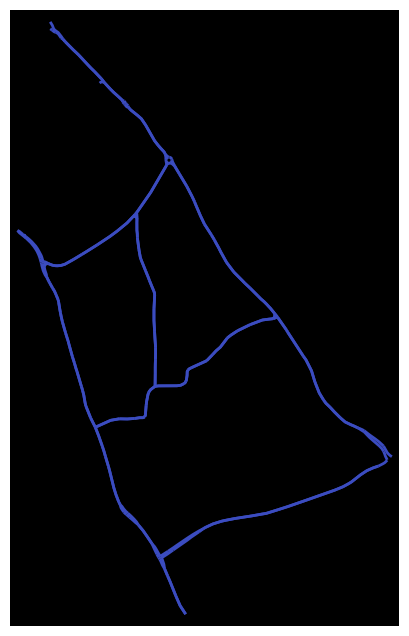

queens_total_eff_cap=  31730.7581270026


In [54]:
number_agents=10000
calculate_edge_betweenness_for_od_pairs(G_queens, od_pairs)
queens_total_eff_cap=calculate_total_effective_capacity(G_queens,number_agents)
plot_eff_cap(G_queens)
print("queens_total_eff_cap= ", queens_total_eff_cap)

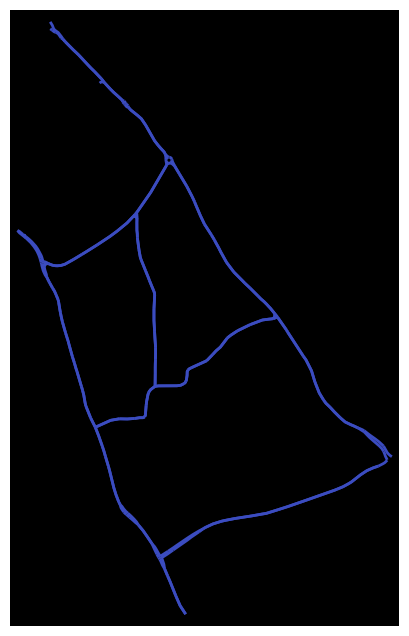

queens_total_eff_cap=  196.46409359075153


In [56]:
number_agents=1
calculate_edge_betweenness_for_od_pairs(G_queens, od_pairs)
queens_total_eff_cap=calculate_total_effective_capacity(G_queens,number_agents)
plot_eff_cap(G_queens)
print("queens_total_eff_cap= ", queens_total_eff_cap)

# Without Queens Road

In [44]:
# Create and adjust the graph
G_no_queens = prepare_and_adjust_graph()

C:\Users\23510\AppData\Local\Temp\ipykernel_3168\183803841.py:26: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead.
  G = ox.graph_from_bbox(north, south, east, west, network_type='drive')


Removed edge (9832649, 9832655) not in the specified names to keep
Removed edge (9832649, 26982635) not in the specified names to keep
Removed edge (9832649, 1043061029) not in the specified names to keep
Removed edge (9832649, 17137858) not in the specified names to keep
Removed edge (9832655, 9832649) not in the specified names to keep
Removed edge (9899517, 26808084) not in the specified names to keep
Removed edge (9922696, 373880128) not in the specified names to keep
Removed edge (9922696, 1043061423) not in the specified names to keep
Removed edge (9922698, 685431851) not in the specified names to keep
Removed edge (9922700, 9922696) not in the specified names to keep
Removed edge (9922703, 27220590) not in the specified names to keep
Removed edge (9922705, 4516239746) not in the specified names to keep
Removed edge (9922712, 14617993) not in the specified names to keep
Removed edge (9922712, 346855492) not in the specified names to keep
Removed edge (9922712, 27220591) not in th

In [45]:

edge_name = "Queens Road"
remove_edges_by_name(G_no_queens, edge_name)

Removed edge (10389694, 6255637709) with name 'Queens Road'
Removed edge (10389694, 6255637714) with name 'Queens Road'
Removed edge (10389699, 297519598) with name 'Queens Road'
Removed edge (10389699, 6255637709) with name 'Queens Road'
Removed edge (10389704, 10389705) with name 'Queens Road'
Removed edge (10389704, 297519598) with name 'Queens Road'
Removed edge (10389705, 10389704) with name 'Queens Road'
Removed edge (10389705, 1112929305) with name 'Queens Road'
Removed edge (10389712, 2164090192) with name 'Queens Road'
Removed edge (10389712, 298259580) with name 'Queens Road'
Removed edge (297519598, 10389704) with name 'Queens Road'
Removed edge (297519598, 10389699) with name 'Queens Road'
Removed edge (298259580, 10389712) with name 'Queens Road'
Removed edge (298259580, 1112929305) with name 'Queens Road'
Removed edge (302067277, 305187710) with name 'Queens Road'
Removed edge (302067277, 2164090192) with name 'Queens Road'
Removed edge (302067279, 302067280) with name 'Q

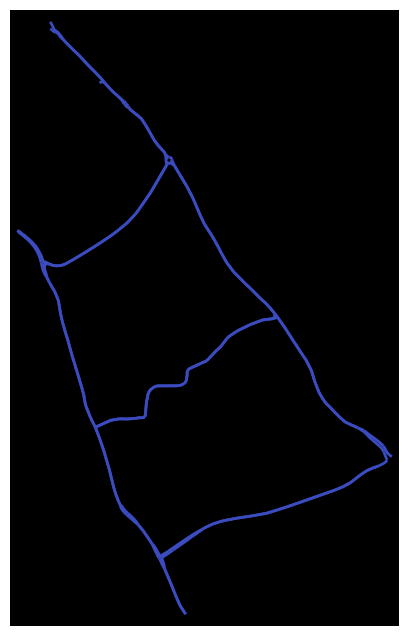

no_queens_total_eff_cap=  27430.06046237738


In [55]:
number_agents =10009 
calculate_edge_betweenness_for_od_pairs(G_no_queens, od_pairs)
no_queens_total_eff_cap=calculate_total_effective_capacity(G_no_queens,number_agents)
plot_eff_cap(G_no_queens)
print("no_queens_total_eff_cap= ", no_queens_total_eff_cap)

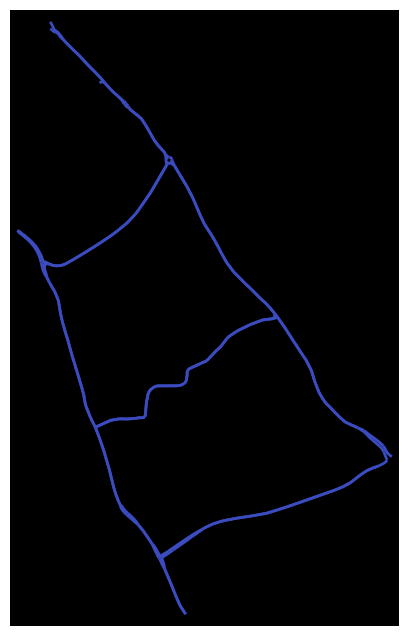

no_queens_total_eff_cap=  200.68844804821993


In [57]:
number_agents =1
calculate_edge_betweenness_for_od_pairs(G_no_queens, od_pairs)
no_queens_total_eff_cap=calculate_total_effective_capacity(G_no_queens,number_agents)
plot_eff_cap(G_no_queens)
print("no_queens_total_eff_cap= ", no_queens_total_eff_cap)

# Results for the two sceniros 

create graphs 

In [59]:
G_queens = prepare_and_adjust_graph()

C:\Users\23510\AppData\Local\Temp\ipykernel_3168\183803841.py:26: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead.
  G = ox.graph_from_bbox(north, south, east, west, network_type='drive')


Removed edge (9832649, 9832655) not in the specified names to keep
Removed edge (9832649, 26982635) not in the specified names to keep
Removed edge (9832649, 1043061029) not in the specified names to keep
Removed edge (9832649, 17137858) not in the specified names to keep
Removed edge (9832655, 9832649) not in the specified names to keep
Removed edge (9899517, 26808084) not in the specified names to keep
Removed edge (9922696, 373880128) not in the specified names to keep
Removed edge (9922696, 1043061423) not in the specified names to keep
Removed edge (9922698, 685431851) not in the specified names to keep
Removed edge (9922700, 9922696) not in the specified names to keep
Removed edge (9922703, 27220590) not in the specified names to keep
Removed edge (9922705, 4516239746) not in the specified names to keep
Removed edge (9922712, 14617993) not in the specified names to keep
Removed edge (9922712, 346855492) not in the specified names to keep
Removed edge (9922712, 27220591) not in th

In [60]:
G_no_queens = prepare_and_adjust_graph()
edge_name = "Queens Road"
remove_edges_by_name(G_no_queens, edge_name)

C:\Users\23510\AppData\Local\Temp\ipykernel_3168\183803841.py:26: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead.
  G = ox.graph_from_bbox(north, south, east, west, network_type='drive')


Removed edge (9832649, 9832655) not in the specified names to keep
Removed edge (9832649, 26982635) not in the specified names to keep
Removed edge (9832649, 1043061029) not in the specified names to keep
Removed edge (9832649, 17137858) not in the specified names to keep
Removed edge (9832655, 9832649) not in the specified names to keep
Removed edge (9899517, 26808084) not in the specified names to keep
Removed edge (9922696, 373880128) not in the specified names to keep
Removed edge (9922696, 1043061423) not in the specified names to keep
Removed edge (9922698, 685431851) not in the specified names to keep
Removed edge (9922700, 9922696) not in the specified names to keep
Removed edge (9922703, 27220590) not in the specified names to keep
Removed edge (9922705, 4516239746) not in the specified names to keep
Removed edge (9922712, 14617993) not in the specified names to keep
Removed edge (9922712, 346855492) not in the specified names to keep
Removed edge (9922712, 27220591) not in th

Set up my agents 

In [116]:
algorithms = ['Dynamic', 'Natural', 'Percieved']
algorithm_weights = [0, 0.7, 0.3]


orig = 2384505898
dest = 248185984
start_nodes = [(orig,1)]
end_nodes = [(dest, 1)]

## these are nodes at each corner of the graph.
orig = [2384505898 , 1074587965]
dest = [248185984, 10868806]
start_nodes = [(orig[0],0.7),(orig[1],0.3)]
end_nodes = [(dest[0],0.7),(dest[1],0.3)]
using_nodes = True




## redundant points, used old functionality 
orig_points = [(Point(52.602725203195455, -1.10647301927566),1)]
dest_points = [(Point(52.62690786081579, -1.119119580305717),1)]


## the graph in the function does not matter when the nodes are specified 
agents2 = generate_agents(G_queens, algorithms, algorithm_weights, orig_points, dest_points, 6, start_nodes, end_nodes,using_nodes)

[(2384505898, 0.7), (1074587965, 0.3)]
[(248185984, 0.7), (10868806, 0.3)]


### Queens road first

In [117]:
other_edge_attributes(G_queens)
all_agent_paths_return, most_common_path, avg_path_len_queens= network_efficiency(G_queens, agents2)


{'osmid': [696621145, 1060126492, 696621143], 'oneway': True, 'ref': 'A6', 'name': 'London Road', 'highway': 'primary', 'maxspeed': '30 mph', 'reversed': False, 'length': 138.154, 'lanes': '4', 'geometry': <LINESTRING (-1.13 52.6, -1.13 52.6, -1.13 52.6, -1.13 52.6, -1.13 52.6, -1....>, 'capacity': 100, 'speed_m/s': 13.4112, 'nat_time': 10.301389883082797, 'usage': 0, 'dyn_time': 10.301389883082797, 'per_time': 10.301389883082797, 'usage_to_capacity': 0.0}
100
{'osmid': 2311883, 'lanes': '4', 'ref': 'A6', 'name': 'London Road', 'highway': 'primary', 'maxspeed': '30 mph', 'oneway': False, 'reversed': False, 'length': 22.268, 'capacity': 100, 'speed_m/s': 13.4112, 'nat_time': 1.6604032450489146, 'usage': 0, 'dyn_time': 1.6604032450489146, 'per_time': 1.6604032450489146, 'usage_to_capacity': 0.0}
100
{'osmid': 4409992, 'oneway': True, 'ref': 'A6', 'name': 'London Road', 'highway': 'primary', 'maxspeed': '30 mph', 'reversed': False, 'length': 14.322, 'capacity': 100, 'speed_m/s': 13.4112, 

In [203]:
import numpy as np

def plot_eff_cap(G, orig, dest, save ):
    """
    Plot a NetworkX graph with edges colored by the ratio of usage to capacity, and highlight and label start and end nodes, with unique road labels.

    Parameters:
    - G (NetworkX Graph): A graph with 'usage' and 'capacity' edge attributes.
    - orig (list): List of starting node IDs.
    - dest (list): List of ending node IDs.

    Effects:
    - Displays a matplotlib plot of the graph with edges colored according to their 'usage_to_capacity' ratio,
      and highlights and labels the start and end nodes and roads.
    """
    usage_to_capacity = []
    for u, v, key, data in G.edges(keys=True, data=True):
        if 'usage' in data and 'capacity' in data and data['capacity'] > 0:
            data['usage_to_capacity'] = data['usage'] / data['capacity']
        else:
            data['usage_to_capacity'] = 0  # Handle cases with missing attributes or zero capacity
        usage_to_capacity.append(data['usage_to_capacity'])

    # Normalize and get edge colors based on 'usage_to_capacity'
    nc = ox.plot.get_edge_colors_by_attr(G, 'usage_to_capacity', cmap='coolwarm')

    # Plot the graph using OSMnx with custom edge colors
    fig, ax = ox.plot_graph(
        G,
        edge_color=nc,
        node_size=0,
        node_zorder=2,
        edge_linewidth=2,
        bgcolor='k',
        show=False,  # Prevent showing the plot immediately
        close=False  # Prevent closing the plot immediately
    )

    # Add title, axis labels, and legend
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=min(usage_to_capacity), vmax=max(usage_to_capacity)))
    sm.set_array([])

    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
    cbar.set_label('Usage to Capacity Ratio', fontsize=14)

    plt.title('Network Graph with Edges Colored by \n Usage to Capacity Ratio', fontsize=16)
    plt.xlabel('Longitude', fontsize=14)
    plt.ylabel('Latitude', fontsize=14)

    # Highlight and label start and end nodes
    start_node_color = 'lime'
    end_node_color = 'red'
    start_node_size = 100
    end_node_size = 100

    for node in orig:
        x, y = G.nodes[node]['x'], G.nodes[node]['y']
        ax.scatter(x, y, c=start_node_color, s=start_node_size, edgecolors='black', label='Start Node')
        ax.annotate(f'Start {node}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center', color='white', fontsize=10)

    for node in dest:
        x, y = G.nodes[node]['x'], G.nodes[node]['y']
        ax.scatter(x, y, c=end_node_color, s=end_node_size, edgecolors='black', label='End Node')
        ax.annotate(f'End {node}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center', color='white', fontsize=10)

    # Label roads uniquely at their midpoints
    road_midpoints = {}
    for u, v, key, data in G.edges(keys=True, data=True):
        if 'name' in data:
            midpoint_x = (G.nodes[u]['x'] + G.nodes[v]['x']) / 2
            midpoint_y = (G.nodes[u]['y'] + G.nodes[v]['y']) / 2
            if data['name'] not in road_midpoints:
                road_midpoints[data['name']] = []
            road_midpoints[data['name']].append((midpoint_x, midpoint_y))

    for road_name, midpoints in road_midpoints.items():
        avg_x = np.mean([x for x, y in midpoints])
        avg_y = np.mean([y for x, y in midpoints])
        ax.annotate(road_name, (avg_x, avg_y), textcoords="offset points", xytext=(0, 10), ha='center', color='white', fontsize=8)

    # Ensure that the legend does not duplicate entries
    handles, labels = ax.get_legend_handles_labels()
    unique_handles = []
    unique_labels = []
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            unique_handles.append(handle)
            unique_labels.append(label)
    ax.legend(unique_handles, unique_labels, fontsize=12)
    
    if save == True:
        file_string = f"{str(G)}_{no_agents}.png"
        plt.savefig(file_string, dpi=600, bbox_inches='tight')
    
    # Show plot
    plt.show()


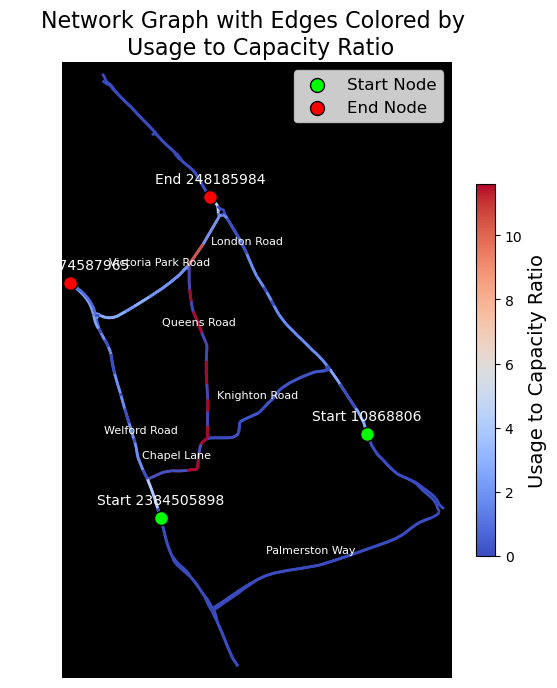

avg_path_len_queens=  543.9584402750442


In [204]:
plot_eff_cap(G_queens, orig, dest, True)
print("avg_path_len_queens= ", avg_path_len_queens)

### Remove Queens Road

In [119]:
other_edge_attributes(G_no_queens)
all_agent_paths_return, most_common_path, avg_path_len_no_queens= network_efficiency(G_no_queens, agents2)

{'osmid': [696621145, 1060126492, 696621143], 'oneway': True, 'ref': 'A6', 'name': 'London Road', 'highway': 'primary', 'maxspeed': '30 mph', 'reversed': False, 'length': 138.154, 'lanes': '4', 'geometry': <LINESTRING (-1.13 52.6, -1.13 52.6, -1.13 52.6, -1.13 52.6, -1.13 52.6, -1....>, 'capacity': 100, 'speed_m/s': 13.4112, 'nat_time': 10.301389883082797, 'usage': 0, 'dyn_time': 10.301389883082797, 'per_time': 10.301389883082797, 'usage_to_capacity': 0.0}
100
{'osmid': 2311883, 'lanes': '4', 'ref': 'A6', 'name': 'London Road', 'highway': 'primary', 'maxspeed': '30 mph', 'oneway': False, 'reversed': False, 'length': 22.268, 'capacity': 100, 'speed_m/s': 13.4112, 'nat_time': 1.6604032450489146, 'usage': 0, 'dyn_time': 1.6604032450489146, 'per_time': 1.6604032450489146, 'usage_to_capacity': 0.0}
100
{'osmid': 4409992, 'oneway': True, 'ref': 'A6', 'name': 'London Road', 'highway': 'primary', 'maxspeed': '30 mph', 'reversed': False, 'length': 14.322, 'capacity': 100, 'speed_m/s': 13.4112, 

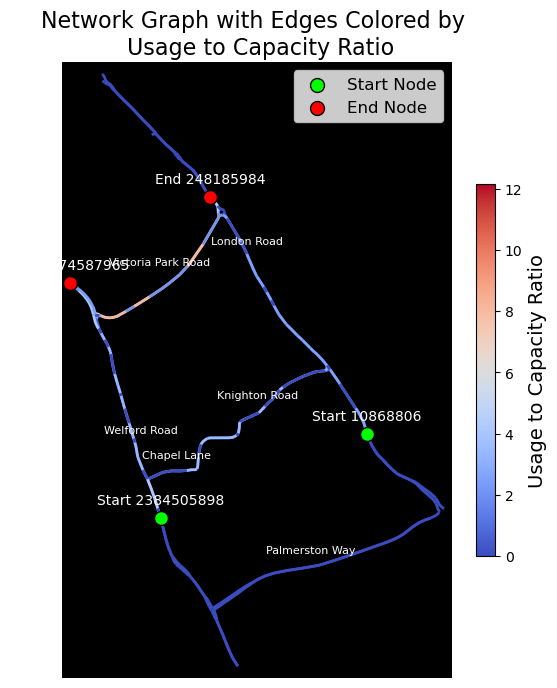

avg_path_len_queens=  397.6587070477165


In [202]:
plot_eff_cap(G_no_queens,orig,dest,True )
print("avg_path_len_queens= ", avg_path_len_no_queens)

# Lets conduct a analysis to see the inflection point 

In [182]:
# starting params:
algorithms = ['Dynamic', 'Natural', 'Percieved']
algorithm_weights = [0,  0.7, 0.3]
## these are nodes at each corner of the graph.
orig = [2384505898 , 10868806]
dest = [248185984,1074587965 ]
start_nodes = [(orig[0],0.7),(orig[1],0.3)]
end_nodes = [(dest[0],0.7),(dest[1],0.3)]
using_nodes = True

no_agents_list = [5,10,15,20,25,30,40,50,60,70,80,90,100,125,150,175,200,300,400,500,600]
# Initialize lists to store the results
results = []

# Loop through each number of agents
for no_agents in no_agents_list:
    # Generate agents
    agents_ = generate_agents(G_queens, algorithms, algorithm_weights, orig_points, dest_points, no_agents, start_nodes, end_nodes, using_nodes)
    
    # Calculate metrics for network without queens
    other_edge_attributes(G_no_queens)
    _, _, avg_path_len_no_queens = network_efficiency(G_no_queens, agents_)
    
    # Calculate metrics for network with queens
    other_edge_attributes(G_queens)
    _, _, avg_path_len_queens = network_efficiency(G_queens, agents_)
    
    # Append the results to the list
    results.append([no_agents, avg_path_len_no_queens, avg_path_len_queens])

# Create a DataFrame from the results
Braess_v_no_agents = pd.DataFrame(results, columns=['no_agents', 'avg_path_len_no_queens', 'avg_path_len_queens'])

# Optionally, save the DataFrame to a CSV file
Braess_v_no_agents.to_csv('Braess_v_no_agents.csv', index=False)

Braess_v_no_agents

[(2384505898, 0.7), (10868806, 0.3)]
[(248185984, 0.7), (1074587965, 0.3)]
[(2384505898, 0.7), (10868806, 0.3)]
[(248185984, 0.7), (1074587965, 0.3)]
[(2384505898, 0.7), (10868806, 0.3)]
[(248185984, 0.7), (1074587965, 0.3)]
[(2384505898, 0.7), (10868806, 0.3)]
[(248185984, 0.7), (1074587965, 0.3)]
[(2384505898, 0.7), (10868806, 0.3)]
[(248185984, 0.7), (1074587965, 0.3)]
[(2384505898, 0.7), (10868806, 0.3)]
[(248185984, 0.7), (1074587965, 0.3)]
[(2384505898, 0.7), (10868806, 0.3)]
[(248185984, 0.7), (1074587965, 0.3)]
[(2384505898, 0.7), (10868806, 0.3)]
[(248185984, 0.7), (1074587965, 0.3)]
[(2384505898, 0.7), (10868806, 0.3)]
[(248185984, 0.7), (1074587965, 0.3)]
[(2384505898, 0.7), (10868806, 0.3)]
[(248185984, 0.7), (1074587965, 0.3)]
[(2384505898, 0.7), (10868806, 0.3)]
[(248185984, 0.7), (1074587965, 0.3)]
[(2384505898, 0.7), (10868806, 0.3)]
[(248185984, 0.7), (1074587965, 0.3)]
[(2384505898, 0.7), (10868806, 0.3)]
[(248185984, 0.7), (1074587965, 0.3)]
[(2384505898, 0.7), (1086

,no_agents,avg_path_len_no_queens,avg_path_len_queens
0,5,75.778633,75.778633
1,10,49.937361,58.844306
2,15,35.558627,46.585424
3,20,36.279778,47.725054
4,25,43.316818,50.116008
5,30,47.621127,72.593253
6,40,39.126098,46.402360
7,50,45.416852,62.939877
8,60,51.929911,76.177935
9,70,63.272259,91.240362


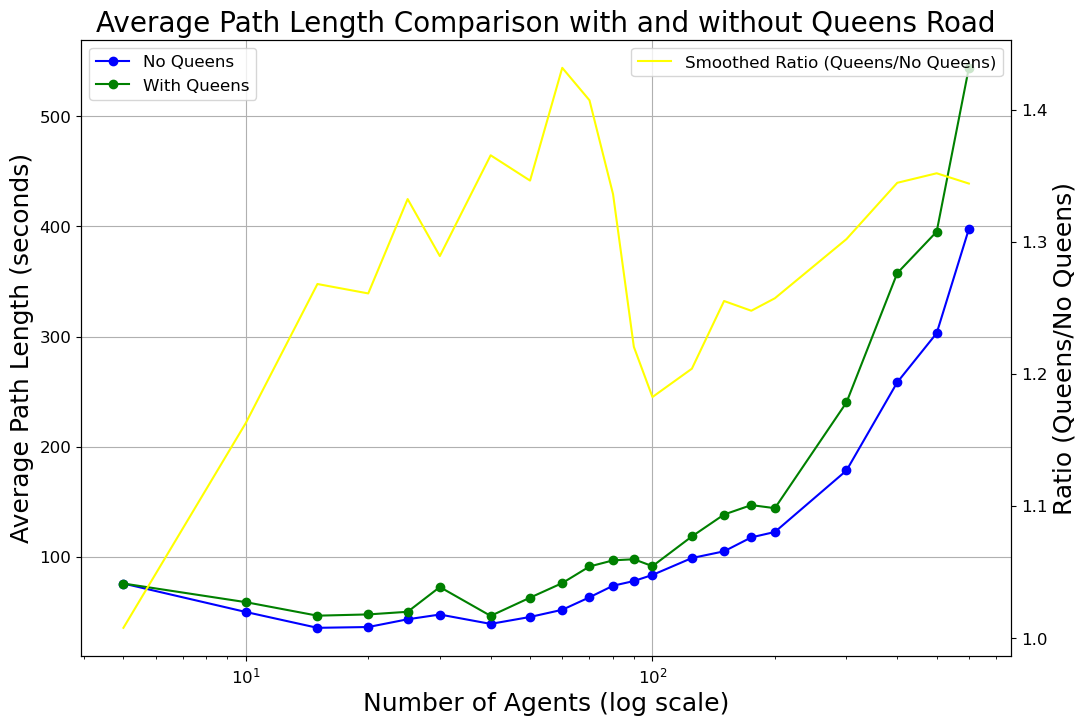

In [192]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

# Calculate the ratio of queens to no queens
df['ratio_queens_no_queens'] = df['avg_path_len_queens'] / df['avg_path_len_no_queens']

# Plot the results
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot the average path lengths
ax1.plot(df['no_agents'], df['avg_path_len_no_queens'], label='No Queens', marker='o', color='blue')
ax1.plot(df['no_agents'], df['avg_path_len_queens'], label='With Queens', marker='o', color='green')

# Set the x-axis to a logarithmic scale
ax1.set_xscale('log')

# Highlight the inflection point where the lines cross
for i in range(len(df) - 1):
    if (df['avg_path_len_no_queens'][i] < df['avg_path_len_queens'][i] and df['avg_path_len_no_queens'][i+1] > df['avg_path_len_queens'][i+1]) or \
       (df['avg_path_len_no_queens'][i] > df['avg_path_len_queens'][i] and df['avg_path_len_no_queens'][i+1] < df['avg_path_len_queens'][i+1]):
        inflection_x = (df['no_agents'][i] + df['no_agents'][i+1]) / 2
        inflection_y_no_queens = (df['avg_path_len_no_queens'][i] + df['avg_path_len_no_queens'][i+1]) / 2
        inflection_y_queens = (df['avg_path_len_queens'][i] + df['avg_path_len_queens'][i+1]) / 2
        inflection_y = (inflection_y_no_queens + inflection_y_queens) / 2
        ax1.scatter(inflection_x, inflection_y, color='red', zorder=5)
        ax1.annotate(f'Inflection Point (x={inflection_x:.2f})', (inflection_x, inflection_y), textcoords="offset points", xytext=(-15, -10), ha='center', color='red')

# Labels and title for the first y-axis
ax1.set_title('Average Path Length Comparison with and without Queens Road', fontsize=20)
ax1.set_xlabel('Number of Agents (log scale)', fontsize=18)
ax1.set_ylabel('Average Path Length (seconds)', fontsize=18)
ax1.legend(loc='upper left', fontsize=12)
ax1.grid(True)

# Increase tick label size
ax1.tick_params(axis='both', which='major', labelsize=12)

# Create a second y-axis to plot the ratio
ax2 = ax1.twinx()
#ax2.plot(df['no_agents'], df['ratio_queens_no_queens'], label='Ratio (Queens/No Queens)', marker='o', color='orange', linestyle='--')

# Smooth the ratio line using Savitzky-Golay filter
smooth_ratio = savgol_filter(df['ratio_queens_no_queens'], window_length=3, polyorder=1)
ax2.plot(df['no_agents'], smooth_ratio, label='Smoothed Ratio (Queens/No Queens)', color='yellow', linestyle='-')

ax2.set_ylabel('Ratio (Queens/No Queens)', fontsize=18)
ax2.legend(loc='upper right', fontsize=12)

# Increase tick label size
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.savefig('network_efficiency_comparison.png', dpi=600, bbox_inches='tight')
plt.show()


# For Only the Braessian OD Pair 

In [16]:
G_queens = prepare_and_adjust_graph()
G_no_queens = prepare_and_adjust_graph()
edge_name = "Queens Road"
remove_edges_by_name(G_no_queens, edge_name)

C:\Users\23510\AppData\Local\Temp\ipykernel_132\183803841.py:26: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead.
  G = ox.graph_from_bbox(north, south, east, west, network_type='drive')


Removed edge (9832649, 9832655) not in the specified names to keep
Removed edge (9832649, 26982635) not in the specified names to keep
Removed edge (9832649, 1043061029) not in the specified names to keep
Removed edge (9832649, 17137858) not in the specified names to keep
Removed edge (9832655, 9832649) not in the specified names to keep
Removed edge (9899517, 26808084) not in the specified names to keep
Removed edge (9922696, 373880128) not in the specified names to keep
Removed edge (9922696, 1043061423) not in the specified names to keep
Removed edge (9922698, 685431851) not in the specified names to keep
Removed edge (9922700, 9922696) not in the specified names to keep
Removed edge (9922703, 27220590) not in the specified names to keep
Removed edge (9922705, 4516239746) not in the specified names to keep
Removed edge (9922712, 14617993) not in the specified names to keep
Removed edge (9922712, 346855492) not in the specified names to keep
Removed edge (9922712, 27220591) not in th

C:\Users\23510\AppData\Local\Temp\ipykernel_132\183803841.py:26: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead.
  G = ox.graph_from_bbox(north, south, east, west, network_type='drive')


Removed edge (9832649, 9832655) not in the specified names to keep
Removed edge (9832649, 26982635) not in the specified names to keep
Removed edge (9832649, 1043061029) not in the specified names to keep
Removed edge (9832649, 17137858) not in the specified names to keep
Removed edge (9832655, 9832649) not in the specified names to keep
Removed edge (9899517, 26808084) not in the specified names to keep
Removed edge (9922696, 373880128) not in the specified names to keep
Removed edge (9922696, 1043061423) not in the specified names to keep
Removed edge (9922698, 685431851) not in the specified names to keep
Removed edge (9922700, 9922696) not in the specified names to keep
Removed edge (9922703, 27220590) not in the specified names to keep
Removed edge (9922705, 4516239746) not in the specified names to keep
Removed edge (9922712, 14617993) not in the specified names to keep
Removed edge (9922712, 346855492) not in the specified names to keep
Removed edge (9922712, 27220591) not in th

In [48]:
# starting params:
algorithms = ['Dynamic', 'Natural', 'Percieved']
algorithm_weights = [0, 0.5 ,0.5 ]
## these are nodes at each corner of the graph.
orig = [2384505898 , 10868806]
dest = [248185984 ,1074587965 ]
orig_points, dest_points = 2,4 ## dummy variable
start_nodes = [(orig[0],1)]#,(orig[1],0.3)]
end_nodes = [(dest[0],1)]#,(dest[1],0.3)]
using_nodes = True

no_agents_list = [1,2,3,4,5,7,10,15,20,25,30,40,50,60,70,80,90,100,125,150,175,200,300,400,500,600]

# Initialize lists to store the results
results = []

# Loop through each number of agents
for no_agents in no_agents_list:
    # Generate agents
    agents_ = generate_agents(G_queens, algorithms, algorithm_weights, orig_points, dest_points, no_agents, start_nodes, end_nodes, using_nodes)
    
    # Calculate metrics for network without queens
    other_edge_attributes(G_no_queens)
    _, _, avg_path_len_no_queens = network_efficiency(G_no_queens, agents_)
    
    # Calculate metrics for network with queens
    other_edge_attributes(G_queens)
    _, _, avg_path_len_queens = network_efficiency(G_queens, agents_)
    
    # Append the results to the list
    results.append([no_agents, avg_path_len_no_queens, avg_path_len_queens])
    
# Create a DataFrame from the results
Braess_v_no_agents = pd.DataFrame(results, columns=['no_agents', 'avg_path_len_no_queens', 'avg_path_len_queens'])

# Optionally, save the DataFrame to a CSV file
Braess_v_no_agents.to_csv('Braess_v_no_agents_single_od_pair.csv', index=False)

Braess_v_no_agents

,no_agents,avg_path_len_no_queens,avg_path_len_queens
0,1,226.643030,204.505003
1,2,228.221652,208.594897
2,3,229.800274,212.684790
3,4,231.378896,216.774683
4,5,232.957518,220.864577
5,7,236.114762,229.044363
6,10,240.850627,236.964250
7,15,248.743737,244.265507
8,20,256.636847,257.887897
9,25,262.898588,264.448075


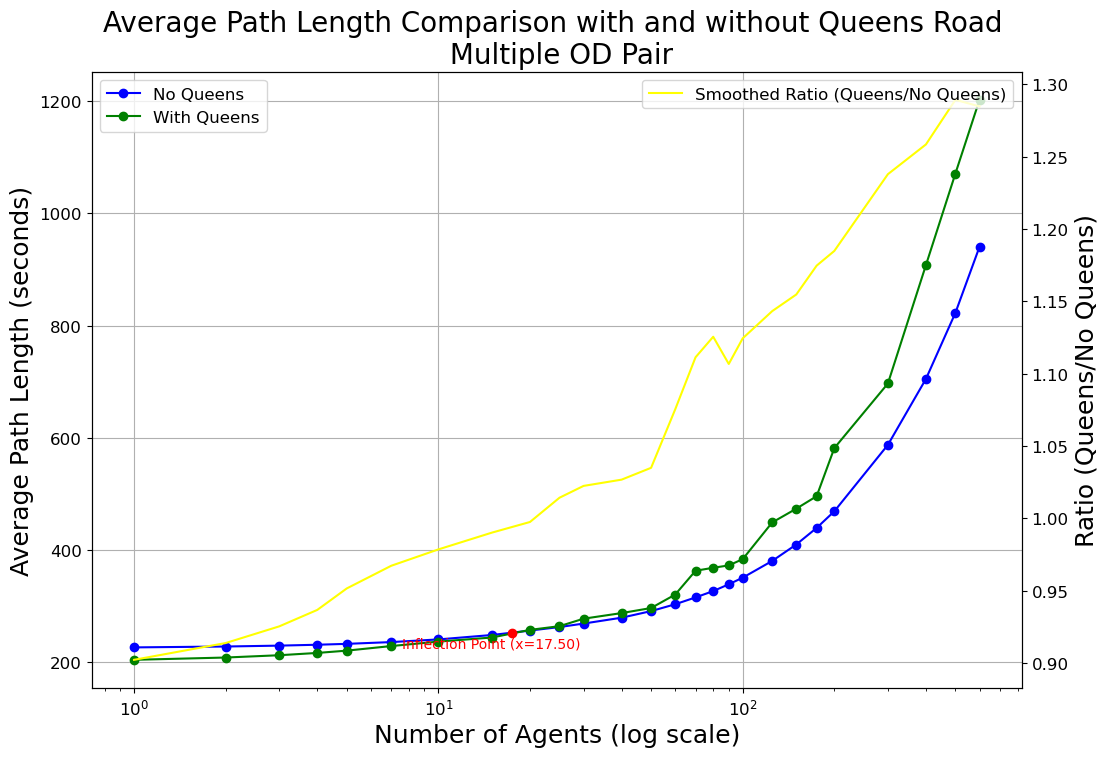

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
df = Braess_v_no_agents
# Calculate the ratio of queens to no queens
df['ratio_queens_no_queens'] = df['avg_path_len_queens'] / df['avg_path_len_no_queens']

# Plot the results
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot the average path lengths
ax1.plot(df['no_agents'], df['avg_path_len_no_queens'], label='No Queens', marker='o', color='blue')
ax1.plot(df['no_agents'], df['avg_path_len_queens'], label='With Queens', marker='o', color='green')

# Set the x-axis to a logarithmic scale
ax1.set_xscale('log')

# Highlight the inflection point where the lines cross
for i in range(len(df) - 1):
    if (df['avg_path_len_no_queens'][i] < df['avg_path_len_queens'][i] and df['avg_path_len_no_queens'][i+1] > df['avg_path_len_queens'][i+1]) or \
       (df['avg_path_len_no_queens'][i] > df['avg_path_len_queens'][i] and df['avg_path_len_no_queens'][i+1] < df['avg_path_len_queens'][i+1]):
        inflection_x = (df['no_agents'][i] + df['no_agents'][i+1]) / 2
        inflection_y_no_queens = (df['avg_path_len_no_queens'][i] + df['avg_path_len_no_queens'][i+1]) / 2
        inflection_y_queens = (df['avg_path_len_queens'][i] + df['avg_path_len_queens'][i+1]) / 2
        inflection_y = (inflection_y_no_queens + inflection_y_queens) / 2
        ax1.scatter(inflection_x, inflection_y, color='red', zorder=5)
        ax1.annotate(f'Inflection Point (x={inflection_x:.2f})', (inflection_x, inflection_y), textcoords="offset points", xytext=(-15, -10), ha='center', color='red')

# Labels and title for the first y-axis
ax1.set_title('Average Path Length Comparison with and without Queens Road \n Multiple OD Pair', fontsize=20)
ax1.set_xlabel('Number of Agents (log scale)', fontsize=18)
ax1.set_ylabel('Average Path Length (seconds)', fontsize=18)
ax1.legend(loc='upper left', fontsize=12)
ax1.grid(True)

# Increase tick label size
ax1.tick_params(axis='both', which='major', labelsize=12)

# Create a second y-axis to plot the ratio
ax2 = ax1.twinx()

# Smooth the ratio line using Savitzky-Golay filter
smooth_ratio = savgol_filter(df['ratio_queens_no_queens'], window_length=3, polyorder=1)
ax2.plot(df['no_agents'], smooth_ratio, label='Smoothed Ratio (Queens/No Queens)', color='yellow', linestyle='-')

ax2.set_ylabel('Ratio (Queens/No Queens)', fontsize=18)
ax2.legend(loc='upper right', fontsize=12)

# Increase tick label size
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.savefig('network_efficiency_comparison_multiple_od_pair2.png', dpi=600, bbox_inches='tight')
plt.show()


In [50]:

plt.close()